In [1]:
import pandas as pd
from collections import Counter

df = pd.read_csv('new_updated_data.csv')

trope_counts = Counter()
for tags in df['tags'].dropna(): 
    trope_list = [t.strip() for t in tags.split(',')]
    trope_counts.update(trope_list)

trope_df = pd.DataFrame.from_dict(trope_counts, orient='index', columns=['Counts'])
trope_df['Percentage'] = (trope_df['Counts'] / len(df)) * 100
trope_df = trope_df.sort_values('Percentage', ascending=False)

In [2]:
# Create DataFrame
trope_df = pd.DataFrame.from_dict(trope_counts, orient='index', columns=['Counts'])

# Calculate Percentage
trope_df['Percentage'] = (trope_df['Counts'] / len(df)) * 100

# Sort by highest percentage
trope_df = trope_df.sort_values('Percentage', ascending=False)

print(trope_df)

                  Counts  Percentage
Fantasy             2342   45.930575
Adventure           1576   30.908021
Young Adult         1436   28.162385
Science fiction     1386   27.181800
Classics            1060   20.788390
...                  ...         ...
multimedia             1    0.019612
Holiday                1    0.019612
Romantic fantasy       1    0.019612
German language        1    0.019612
Introversion           1    0.019612

[774 rows x 2 columns]


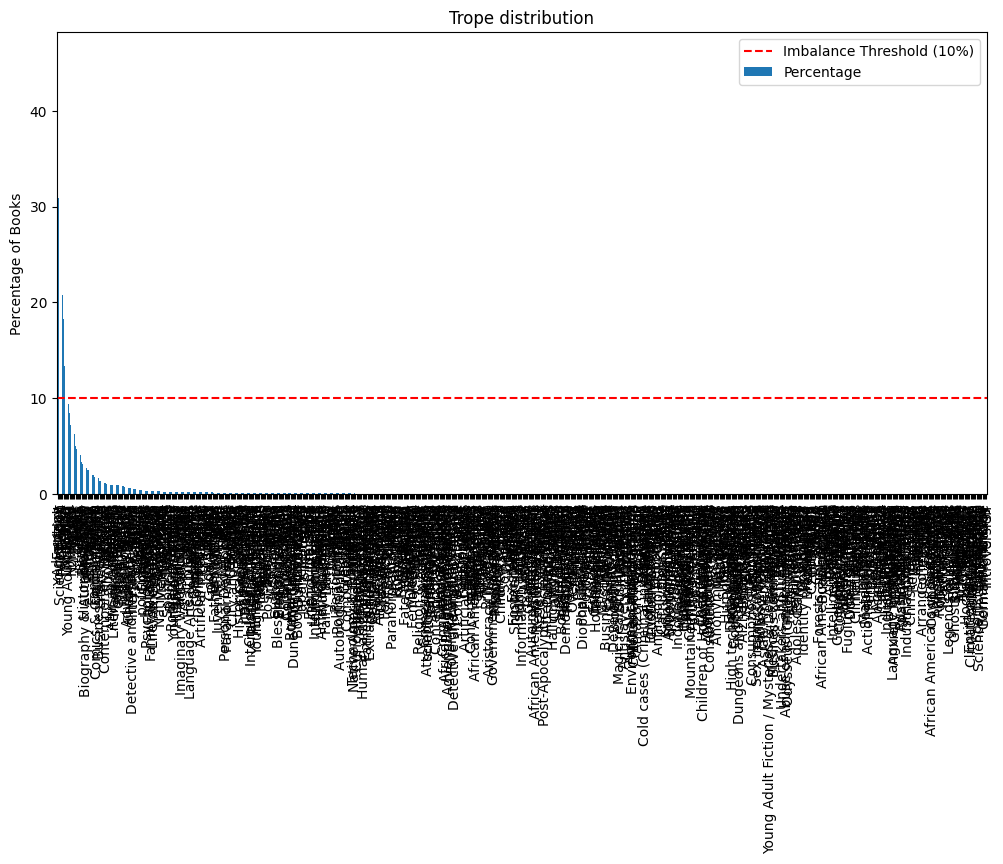

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
trope_df['Percentage'].plot(kind='bar')
plt.title("Trope distribution")
plt.ylabel("Percentage of Books")
plt.axhline(y=10, color='r', linestyle='--', label='Imbalance Threshold (10%)')  # <-- axhline, not axline
plt.legend()
plt.show()


In [4]:
import csv
import json

# Input CSV file path
csv_file_path = 'new_updated_data.csv'

# Output JSON file path
json_file_path = 'imbalanced.json'

# List to hold all rows
data = []

# Open CSV and read it
with open(csv_file_path, mode='r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # Optional: Convert numbers (rating, pages) and date if needed
        row['id'] = int(row['id'])
        row['rating'] = float(row['rating']) if row['rating'] else None
        row['pages'] = int(row['pages']) if row['pages'] else None
        # Keep all other fields as string
        data.append(row)

# Write JSON output
with open(json_file_path, mode='w', encoding='utf-8') as jsonfile:
    json.dump(data, jsonfile, indent=4, ensure_ascii=False)

print(f"CSV data has been converted to JSON and saved to {json_file_path}.")


CSV data has been converted to JSON and saved to imbalanced.json.


In [5]:
import json

# Input JSON file path
input_json_file = 'imbalanced.json'

# Output JSON file for unknown genre books
output_unknown_genre_file = 'unknown_genre_books.json'

# Load the existing JSON data
with open(input_json_file, mode='r', encoding='utf-8') as jsonfile:
    data = json.load(jsonfile)

# Filter entries where genre is 'Unknown'
unknown_genre_books = [book for book in data if book['genre'].strip().lower() == 'unknown']

# Save filtered data to new JSON file
with open(output_unknown_genre_file, mode='w', encoding='utf-8') as outfile:
    json.dump(unknown_genre_books, outfile, indent=4, ensure_ascii=False)

# Print how many unknowns were found
print(f"Total 'Unknown' genre books found: {len(unknown_genre_books)}")
print(f"Filtered entries saved into {output_unknown_genre_file}.")


Total 'Unknown' genre books found: 706
Filtered entries saved into unknown_genre_books.json.


In [10]:
import json
from collections import Counter

# Load your dataset
with open("imbalanced.json", "r", encoding="utf-8") as f:
    books = json.load(f)

# Step 1: Flatten and count all tags
tag_counter = Counter()
for book in books:
    tags = [tag.strip() for tag in book.get("tags", "").split(",") if tag.strip()]
    tag_counter.update(tags)

# Step 2: Keep only tags with frequency >= 25
MIN_FREQUENCY = 10
frequent_tags = {tag for tag, count in tag_counter.items() if count >= MIN_FREQUENCY}

# Step 3: Filter books and tags
cleaned_books = []
for book in books:
    raw_tags = [tag.strip() for tag in book.get("tags", "").split(",") if tag.strip()]
    filtered_tags = [tag for tag in raw_tags if tag in frequent_tags]

    # Keep books with at least 2 frequent tags
    if len(filtered_tags) >= 2:
        book["tags"] = ", ".join(filtered_tags)
        cleaned_books.append(book)

# Step 4: Save the cleaned dataset
with open("cleaned_books.json", "w") as f:
    json.dump(cleaned_books, f, indent=2)

print(f"Original books: {len(books)}")
print(f"Cleaned books: {len(cleaned_books)}")


Original books: 5099
Cleaned books: 3593


In [11]:
import json
import pandas as pd

# Load the dataset
with open("cleaned_books.json", "r") as f:
    books = json.load(f)

# Load tag mapping CSV
df_map = pd.read_csv("tag_consolidation_mappings.csv")

# Build mapping dicts
tag_to_cluster = dict(zip(df_map["Original_Tag"].str.lower(), df_map["Cluster"]))
tag_actions = dict(zip(df_map["Original_Tag"].str.lower(), df_map["Action"]))

def transform_tags(raw_tag_string):
    raw_tags = [tag.strip() for tag in raw_tag_string.split(",") if tag.strip()]
    final_tags = set()

    for tag in raw_tags:
        tag_l = tag.lower()
        action = tag_actions.get(tag_l, "Keep")  # default: Keep

        if action == "Remove":
            continue
        elif action == "Consolidate":
            final_tags.add(tag_to_cluster[tag_l])
        else:  # Keep
            final_tags.add(tag_to_cluster.get(tag_l, tag))  # fallback to original

    return list(final_tags)

# Apply transformation
clustered_books = []
for book in books:
    if not book.get("tags"):
        continue
    new_tags = transform_tags(book["tags"])
    if len(new_tags) >= 2:
        book["tags"] = ", ".join(sorted(new_tags))
        clustered_books.append(book)

# Save clustered result
with open("clustered_books.json", "w") as f:
    json.dump(clustered_books, f, indent=2)

print(f"Books after clustering: {len(clustered_books)}")


Books after clustering: 3422


In [12]:
genre_hierarchy = {
    "Speculative Fiction": {"Fantasy", "Science Fiction", "Horror", "Dystopian"},
    "Literary Fiction": {"Fiction", "Classics", "Literary Fiction"},
    "Youth Literature": {"Young Adult", "Children's Fiction", "Middle Grade"},
    "Adventure/Action": {"Adventure", "Action & Adventure", "Thriller"},
    "Romance/Relationships": {"Romance", "Contemporary Romance", "Historical Romance"},
    "Mystery/Crime": {"Mystery", "Crime Fiction", "Detective"},
    "Non-Fiction": {"Nonfiction", "Biography", "History", "Science"},
    "Reference/Academic": {"Religion & Philosophy", "Business & Economics"},
}


In [13]:
import json

# Load clustered dataset
with open("clustered_books.json", "r") as f:
    books = json.load(f)

# Reverse mapping: genre → category
flat_mapping = {}
for category, genre_set in genre_hierarchy.items():
    for g in genre_set:
        flat_mapping[g.lower()] = category

# Function to map genre
def map_genre(original_genre):
    genre_lc = original_genre.lower().strip()
    return flat_mapping.get(genre_lc, "Other")  # fallback if genre not in mapping

# Apply mapping
for book in books:
    original_genre = book.get("genre", "")
    book["genre_category"] = map_genre(original_genre)

# Save updated dataset
with open("hierarchical_books.json", "w") as f:
    json.dump(books, f, indent=2)

print("Genre hierarchy applied. Sample categories:")
for b in books[:5]:
    print(f'{b["title"]}: {b["genre"]} → {b["genre_category"]}')


Genre hierarchy applied. Sample categories:
Notes from Underground: Fiction → Literary Fiction
Holding Up the Universe: Young Adult → Youth Literature
Cell: Horror → Speculative Fiction
Dreams from My Father: A Story of Race and Inheritance: History → Non-Fiction
Needful Things: Fantasy → Speculative Fiction


In [14]:
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Load data from previous phase
with open("hierarchical_books.json", "r") as f:
    books = json.load(f)

# Extract book metadata
df = pd.DataFrame(books)

# Fill missing tags with empty string
df["tags"] = df["tags"].fillna("")

# Vectorize the tags with TF-IDF
tfidf = TfidfVectorizer(tokenizer=lambda x: [tag.strip() for tag in x.split(",") if tag.strip()],
                        lowercase=True)
X = tfidf.fit_transform(df["tags"])

# Apply SVD (Truncated for sparse matrices)
n_components = 50  # Tune this based on explained variance or use elbow method
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_reduced = svd.fit_transform(X)

# Add latent features to DataFrame
latent_df = pd.DataFrame(X_reduced, columns=[f"latent_feature_{i+1}" for i in range(n_components)])
df_latent = pd.concat([df[["id", "title", "genre", "genre_category"]], latent_df], axis=1)

# Save as JSON or CSV
df_latent.to_json("books_with_latent_features.json", orient="records", indent=2)
df_latent.to_csv("books_with_latent_features.csv", index=False)

print(f"Latent features added: {n_components} dimensions")


c:\Users\maheit\dev\book\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Latent features added: 50 dimensions


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Load the processed data
df_latent = pd.read_csv("books_with_latent_features.csv")
df_original = pd.DataFrame(books)  # Your original data

# Set up the plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. Genre Distribution Analysis - FIXED VERSION
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Genre distribution
genre_counts = df_original['genre'].value_counts()
axes[0,0].pie(genre_counts.values, labels=genre_counts.index, autopct='%1.1f%%')
axes[0,0].set_title('Genre Distribution')

# Genre category distribution - CORRECTED
category_counts = df_original['genre_category'].value_counts()
# Option 1: Use seaborn's automatic counting
sns.countplot(data=df_original, y='genre_category', ax=axes[0,1], order=category_counts.index)
axes[0,1].set_title('Genre Category Distribution')

# Alternative fix - Option 2: Create barplot without data parameter
# axes[0,1].barh(range(len(category_counts)), category_counts.values)
# axes[0,1].set_yticks(range(len(category_counts)))
# axes[0,1].set_yticklabels(category_counts.index)
# axes[0,1].set_title('Genre Category Distribution')

# Rating distribution by genre
sns.boxplot(data=df_original, x='rating', y='genre', ax=axes[1,0])
axes[1,0].set_title('Rating Distribution by Genre')
axes[1,0].tick_params(axis='y', labelsize=8)

# Pages vs Rating scatter
sns.scatterplot(data=df_original, x='pages', y='rating', hue='genre', ax=axes[1,1])
axes[1,1].set_title('Pages vs Rating by Genre')
axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# 2. Latent Feature Space Visualization using t-SNE
latent_features = df_latent.iloc[:, 4:].values  # Extract latent features

# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(df_latent)-1))
tsne_result = tsne.fit_transform(latent_features)

# Create interactive t-SNE plot
fig_tsne = px.scatter(
    x=tsne_result[:, 0], 
    y=tsne_result[:, 1],
    color=df_latent['genre_category'],
    hover_data={'title': df_latent['title'], 
                'author': df_original['author'],
                'rating': df_original['rating']},
    title="t-SNE Visualization of Book Latent Features",
    labels={'x': 't-SNE 1', 'y': 't-SNE 2'}
)
fig_tsne.show()

# 3. K-means Clustering on Latent Features
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(latent_features)

# Visualize clusters
fig_cluster = px.scatter(
    x=tsne_result[:, 0], 
    y=tsne_result[:, 1],
    color=clusters.astype(str),
    hover_data={'title': df_latent['title'], 
                'genre': df_latent['genre'],
                'rating': df_original['rating']},
    title=f"K-means Clustering (k={n_clusters}) on Latent Features",
    labels={'x': 't-SNE 1', 'y': 't-SNE 2', 'color': 'Cluster'}
)
fig_cluster.show()

# 4. Tag Analysis and Frequency
all_tags = []
for tags in df_original['tags'].dropna():
    all_tags.extend([tag.strip() for tag in tags.split(',') if tag.strip()])

tag_freq = Counter(all_tags)
top_tags = dict(tag_freq.most_common(20))

# Tag frequency bar chart
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=list(top_tags.values()), y=list(top_tags.keys()), ax=ax)
ax.set_title('Top 20 Most Frequent Tags')
ax.set_xlabel('Frequency')
plt.tight_layout()
plt.show()

# 5. Advanced Analytics Dashboard
fig_dash = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Rating Distribution', 'Books per Genre Category', 
                   'Pages vs Rating', 'Tag Cloud Data'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# Rating histogram
fig_dash.add_trace(
    go.Histogram(x=df_original['rating'], name='Rating', nbinsx=20),
    row=1, col=1
)

# Genre category counts
fig_dash.add_trace(
    go.Bar(
        y=category_counts.index,
        x=category_counts.values,
        orientation='h',
        name='Genre Categories',
        showlegend=False
    ),
    row=1, col=2
)

# Pages vs Rating scatter
fig_dash.add_trace(
    go.Scatter(
        x=df_original['pages'],
        y=df_original['rating'],
        mode='markers',
        name='Books',
        text=df_original['title'],
        showlegend=False
    ),
    row=2, col=1
)

# Top tags bar chart
fig_dash.add_trace(
    go.Bar(
        y=list(top_tags.keys())[:10],  # Top 10 tags
        x=list(top_tags.values())[:10],
        orientation='h',
        name='Top Tags',
        showlegend=False
    ),
    row=2, col=2
)

fig_dash.update_layout(height=800, title_text="Book Dataset Analysis Dashboard")
fig_dash.show()

# 6. Recommendation System Performance Metrics
from sklearn.metrics.pairwise import cosine_similarity

# Calculate similarity matrix for sample of books
sample_size = min(100, len(df_latent))
sample_latent = latent_features[:sample_size]
similarity_matrix = cosine_similarity(sample_latent)

# Create similarity heatmap
fig_sim = px.imshow(
    similarity_matrix,
    labels=dict(x="Book Index", y="Book Index", color="Cosine Similarity"),
    title=f"Book Similarity Matrix (Sample of {sample_size} books)"
)
fig_sim.show()

# 7. Genre-based Analysis
genre_stats = df_original.groupby('genre_category').agg({
    'rating': ['mean', 'std', 'count'],
    'pages': ['mean', 'median'],
}).round(2)

print("Genre Statistics:")
print(genre_stats)

# 8. Latent Feature Variance Analysis
feature_variance = np.var(latent_features, axis=0)
cumulative_variance = np.cumsum(feature_variance) / np.sum(feature_variance)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(feature_variance[:20])  # First 20 features
plt.title('Variance per Latent Feature (First 20)')
plt.xlabel('Latent Feature Index')
plt.ylabel('Variance')

plt.subplot(1, 2, 2)
plt.plot(cumulative_variance)
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Ratio')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Variance')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% Variance')
plt.legend()

plt.tight_layout()
plt.show()

print("\nDataset Summary:")
print(f"- Total books: {len(df_original)}")
print(f"- Unique genres: {df_original['genre'].nunique()}")
print(f"- Unique genre categories: {df_original['genre_category'].nunique()}")
print(f"- Average rating: {df_original['rating'].mean():.2f}")
print(f"- Average pages: {df_original['pages'].mean():.0f}")
print(f"- Most common tag: '{tag_freq.most_common(1)[0][0]}' ({tag_freq.most_common(1)[0][1]} books)")
print(f"- Latent features created: {latent_features.shape[1]}")


ModuleNotFoundError: No module named 'plotly'